In [1]:
#download data from kaggle
!pip install opendatasets --quiet

In [9]:
pip install xgboost lightgbm  --quiet

In [3]:
!pip install -U scikit-learn==1.7.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [4]:
import shap
import joblib
import pandas as pd
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt

In [5]:
od.download("https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data?select=loan_data.csv")
#hemantk777  721b095dacb7cfa6129768282921b8fb

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hemantk777
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data


100%|██████████| 751k/751k [00:00<00:00, 417MB/s]

In [6]:
data=pd.read_csv("/content/loan-approval-classification-data/loan_data.csv")

In [11]:
X = data.drop("loan_status", axis=1)
y = data["loan_status"]

In [7]:
# Load your pipeline and data
pipeline = joblib.load("/content/loan_pipeline.pkl")

In [8]:
pipeline.named_steps

{'preprocess': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['person_age', 'person_income',
                                   'person_emp_exp', 'loan_amnt',
                                   'loan_int_rate', 'loan_percent_income',
                                   'cb_person_cred_hist_length',
                                   'credit_score']),
                                 ('cat',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['person_gender', 'person_education',
                                   'person_home_ownership', 'loan_intent',
                                   'previous_loan_defaults_on_file'])]),
 'model': LogisticRegression()}

In [13]:
# Get transformed feature names from ColumnTransformer
feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()

In [14]:
# Get preprocessed numeric features
X_transformed = pipeline.named_steps['preprocess'].transform(X)
# Convert transformed array back to DataFrame with correct column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Train XGBoost

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
print("🔷 XGBoost Performance:")
print(classification_report(y_test, xgb_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:32:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔷 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.89      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.93      0.93      9000



# Train LightGBM

In [17]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)
print("🟢 LightGBM Performance:")
print(classification_report(y_test, lgb_preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7990, number of negative: 28010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221944 -> initscore=-1.254371
[LightGBM] [Info] Start training from score -1.254371
🟢 LightGBM Performance:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.89      0.79      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.88      0.90      9000
weighted avg       0.93      0.93      0.93      9000



# Compare Feature Importances

<Figure size 1200x600 with 0 Axes>

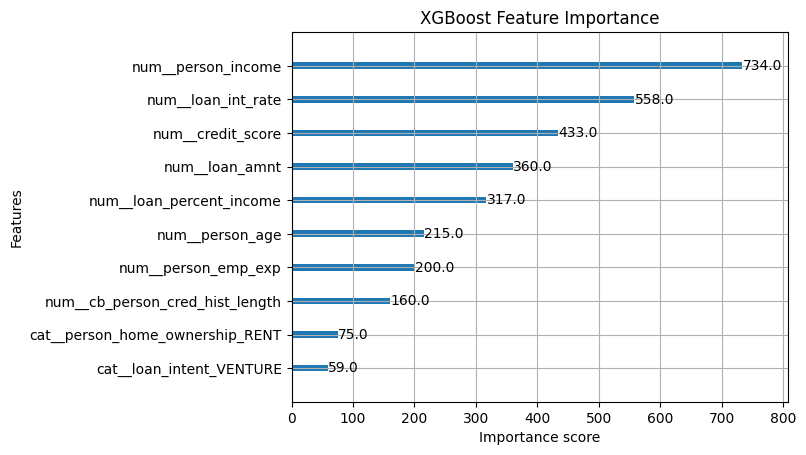

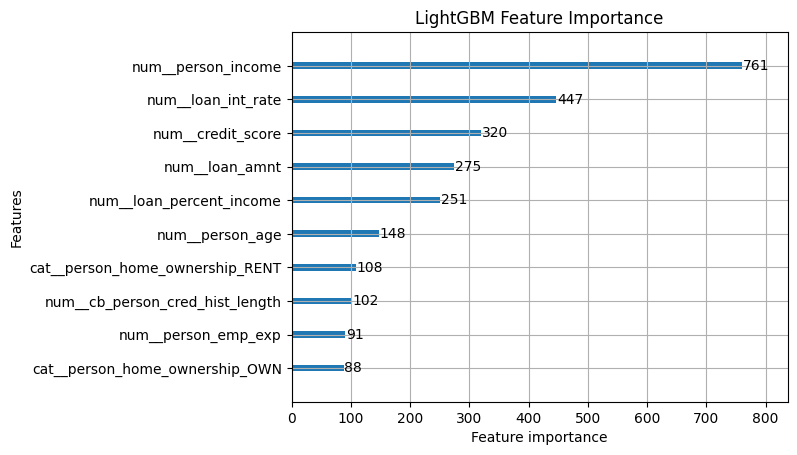

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=10, title="XGBoost Feature Importance")
plt.savefig("XGBoost Feature Importance.png", dpi=300, bbox_inches='tight')
plt.show()

lgb.plot_importance(lgb_model, max_num_features=10, title="LightGBM Feature Importance")
plt.savefig("LightGBM Feature Importance.png", dpi=300, bbox_inches='tight')
plt.show()


# ⚔️ LightGBM vs XGBoost: Key Differences

| Feature          | XGBoost        | LightGBM                     |
| ---------------- | -------------- | ---------------------------- |
| Tree Growth      | Level-wise     | Leaf-wise (faster)           |
| Speed            | Slower         | Faster                       |
| Accuracy         | High           | High                         |
| Handling Missing | Native support | Native support               |
| Parallelism      | Efficient      | More efficient               |
| Interpretability | Good           | Good (but less SHAP support) |
